# Using LLMs as Generalist Text Embedding Models - NVEmbed Model Review 

Code for the [blog post](https://newsletter.victordibia.com/p/using-llms-as-context-aware-text) on using LLMs as generalist text embedding models. 

We will explore the NV-Embed model,  a generalist embedding model based on Mistral 7B

Note: the model requires a [specific version](https://huggingface.co/nvidia/NV-Embed-v2#2-required-packages) of the transformers library.

```bash 
pip uninstall -y transformer-engine
pip install torch==2.2.0
pip install transformers==4.42.4
pip install flash-attn==2.2.0
pip install sentence-transformers==2.7.0

```

In [1]:
# !pip install seaborn

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gc
import os
from tqdm import tqdm
import pandas as pd
import altair as alt


# Set PyTorch to use expandable segments to avoid fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# note, you will need to have a GPU to run this code
def load_model(model_name='nvidia/NV-Embed-v2'):
    return AutoModel.from_pretrained(model_name, trust_remote_code=True, device_map="auto")

model = load_model()

/home/victordibia/miniconda3/envs/autohf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/victordibia/miniconda3/envs/autohf/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- configuration_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- modeling_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid dow

In [3]:
def get_embeddings(model, texts, instruction, max_length=32768, batch_size=60):
    """
    Get embeddings for a list of texts with a specific instruction.
    Modify batch_size based on your GPU memory.
    """
    prefix = f"Instruct: {instruction}\nQuery: " if instruction else ""
    
    if len(texts) <= batch_size:
        embeddings = model.encode(texts, instruction=prefix, max_length=max_length, truncation=True)
        return F.normalize(embeddings, p=2, dim=1)
    
    # Process in batches
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        # Clear GPU cache before each batch
        # if torch.cuda.is_available():
        #     torch.cuda.empty_cache()
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch_texts, instruction=prefix, max_length=max_length)
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all batches
    embeddings = torch.cat(all_embeddings, dim=0)
    return F.normalize(embeddings, p=2, dim=1)

def get_scores(embeddings1, embeddings2):
    """
    Calculate similarity scores between two sets of embeddings.
    Ensures that both sets of embeddings have the same dimensions.
    """
    if embeddings1.shape[1] != embeddings2.shape[1]:
        raise ValueError("Embedding dimensions do not match. Please ensure both sets of embeddings have the same dimensionality.")
    return (embeddings1 @ embeddings2.T) * 100

def reduce_dimensions(embeddings, n_components=2, method='tsne'):
    """
    Reduce dimensions of embeddings using t-SNE (default) or PCA.
    
    Args:
    embeddings: Input embeddings (numpy array or torch.Tensor)
    n_components: Number of components in reduced space (default: 2)
    method: Reduction method, either 'tsne' or 'pca' (default: 'tsne')
    
    Returns:
    Reduced embeddings as a numpy array
    """
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()
    
    if n_components and n_components < embeddings.shape[1]:
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42)
        elif method.lower() == 'pca':
            reducer = PCA(n_components=n_components)
        else:
            raise ValueError("Method must be either 'tsne' or 'pca'")
        
        return reducer.fit_transform(embeddings)
    return embeddings

def process_embeddings(model, texts, instruction, task_type, n_components=None):
    """
    Process embeddings based on the task type (e.g., clustering, classification).
    Optionally reduce dimensions if n_components is specified.
    """
    embeddings = get_embeddings(model, texts, instruction) 
    
    embeddings = reduce_dimensions(embeddings, n_components)
    
    if task_type == "clustering":
        # For clustering, we might want to keep the reduced dimensions
        return embeddings
    
    elif task_type == "classification":
        # For classification, we might want to use the full embeddings
        return embeddings
    
    else:
        return embeddings

def flush_memory():
    """
    Flush GPU memory and run garbage collection.
    """
    torch.cuda.empty_cache()
    gc.collect()

In [14]:
import pandas as pd
import re

# df = pd.read_json('yc_data.json')
df = pd.read_json('https://raw.githubusercontent.com/akshaybhalotia/yc_company_scraper/refs/heads/main/data/combined_companies_data.json') 
df["one_liner"] = df.one_liner.fillna("").astype(str)
df["long_description"] = df.long_description.fillna("").astype(str)
df["desc"] = df.one_liner + " " + df.long_description 
df["short"] = df.name + " \n " + df.one_liner

original_length = len(df) 
df = df[df['desc'].notna() & (df['desc'].str.len() >= 5)] 
rows_dropped = original_length - len(df)

print(f"Dropped {rows_dropped} rows where 'desc' was NaN or had length less than 5.")
print(f"New DataFrame length: {len(df)}")


# Compile patterns for efficiency (do this outside the functions)
AI_REGEX = re.compile(r'\bai\b|artificial intelligence|machine learning|llm|nlp|ai-power')
AGENT_REGEX = re.compile(r'\bagents?\b')
HEALTH_REGEX = re.compile(r'''
    \b(health(care)?|medical|medicine|med(i)?tech|pharma(ceuticals?)?|biotech|
    wellness|fitness|nutrition|therapy|mental[\s-]health|telemedicine|
    diagnosis|treatment|patient|doctor|hospital|clinic|drug|vaccine|
    health[\s-]tech|life[\s-]sciences?|genomics?|bioinformatics)\b
''', re.VERBOSE | re.IGNORECASE)

def mentions_ai(text):
    if not isinstance(text, str):
        return False
    return bool(AI_REGEX.search(text.lower()))

def mentions_ai_agents(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    return bool(AI_REGEX.search(text) and AGENT_REGEX.search(text))

df["mentions_ai_agents"] = df.desc.apply(mentions_ai_agents)
df["mentions_ai"] = df.desc.apply(mentions_ai)
df["mentions_health"] = df.desc.apply(lambda x: bool(HEALTH_REGEX.search(x.lower())))
df.head(3)

df.to_json('data/yc_data.json', orient='records' )

Dropped 58 rows where 'desc' was NaN or had length less than 5.
New DataFrame length: 4779


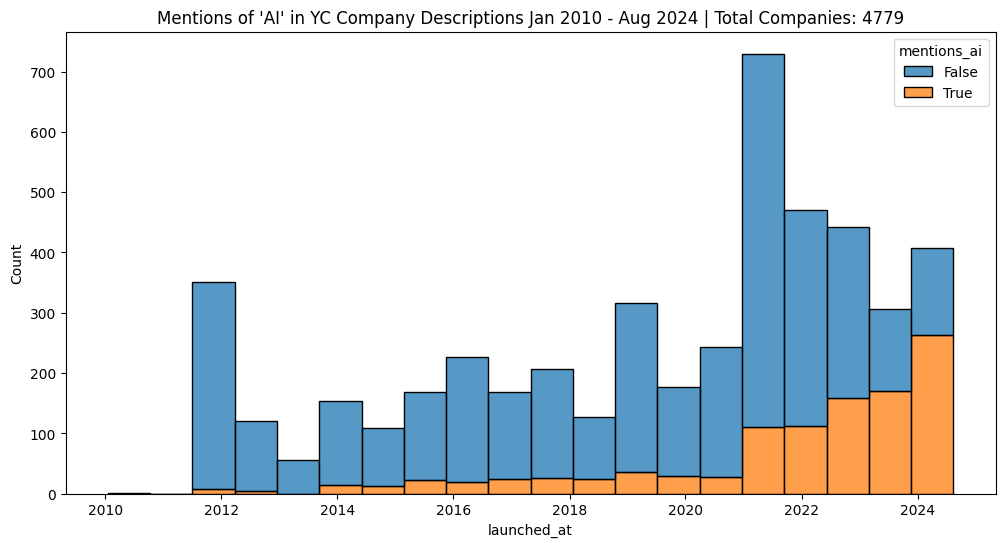

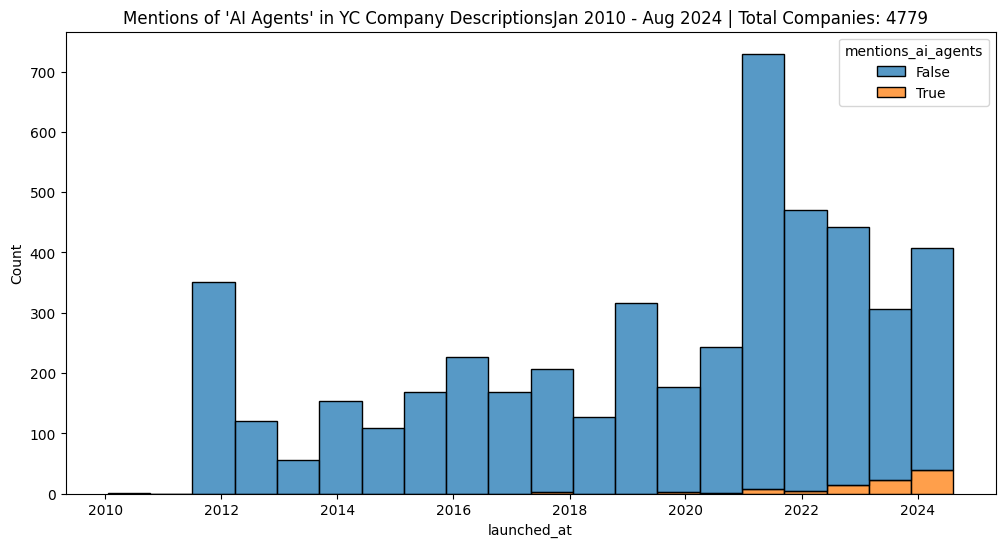

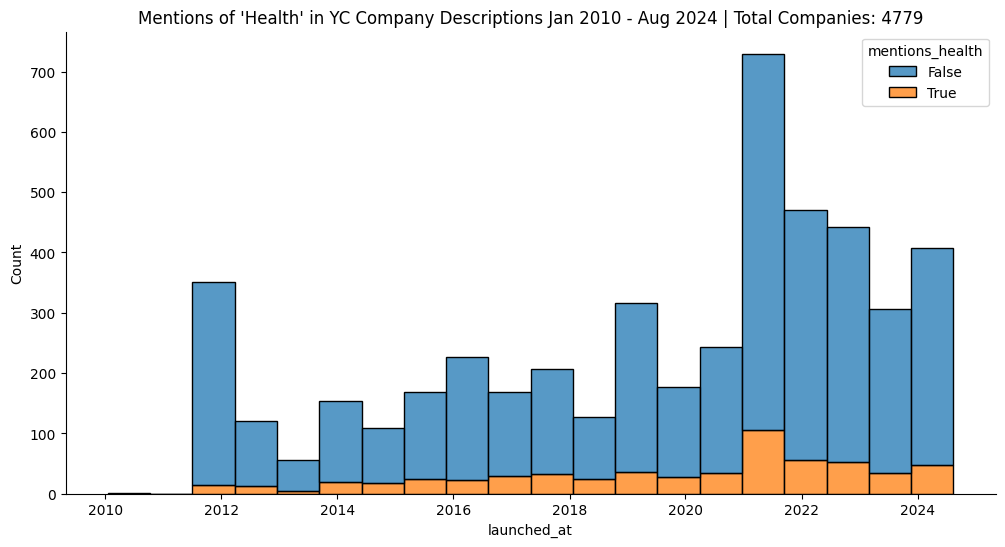

In [5]:
# sns plot of companies by launched_at colored by whether they mention AI

import seaborn as sns
import matplotlib.pyplot as plt

date_range = f"{df.launched_at.min().strftime('%b %Y')} - {df.launched_at.max().strftime('%b %Y')}"
plt.figure(figsize=(12, 6))
sns.histplot(df, x="launched_at", hue="mentions_ai", multiple="stack", bins=20); 
plt.title(f"Mentions of 'AI' in YC Company Descriptions {date_range} | Total Companies: {len(df)}")

plt.figure(figsize=(12, 6))
sns.histplot(df, x="launched_at", hue="mentions_ai_agents", multiple="stack", bins=20);
plt.title(f"Mentions of 'AI Agents' in YC Company Descriptions{date_range} | Total Companies: {len(df)}  ")

plt.figure(figsize=(12, 6))
sns.histplot(df, x="launched_at", hue="mentions_health", multiple="stack", bins=20);
plt.title(f"Mentions of 'Health' in YC Company Descriptions {date_range} | Total Companies: {len(df)}")

# remove plot frame 
sns.despine()


In [6]:
import pandas as pd
import altair as alt
import json 

def plot_clusters(reduced_dims, mdf, color_by='mentions_ai', title=None, width=8, height=4):
    # Ensure mdf has the same number of rows as reduced_dims
    if len(reduced_dims) != len(mdf):
        print(f"Warning: reduced_dims ({len(reduced_dims)} rows) and mdf ({len(mdf)} rows) have different sizes.")
        print("Subsetting mdf to match reduced_dims size.")
        mdf = mdf.iloc[:len(reduced_dims)].copy()

    df = pd.DataFrame(reduced_dims, columns=["x", "y"])
    
    # Dynamically add all columns from mdf to df
    for col in mdf.columns:
        df[col] = mdf[col].values

    # Ensure the color_by column exists
    if color_by not in df.columns:
        raise ValueError(f"The column '{color_by}' is not present in the dataframe.")

    fig, ax = plt.subplots(figsize=(width, height))

    # Determine color scale based on the data type of the color_by column
    if df[color_by].dtype == 'bool':
        color_map = {True: "#1f77b4", False: "#ff7f0e"}
        colors = [color_map[val] for val in df[color_by]]
    elif df[color_by].dtype == 'object' or df[color_by].dtype.name == 'category':
        unique_categories = df[color_by].unique()
        color_map = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_categories)))
        color_dict = dict(zip(unique_categories, color_map))
        colors = [color_dict[val] for val in df[color_by]]
    else:  # Assuming numerical data for any other type
        colors = plt.cm.viridis(plt.Normalize()(df[color_by]))

    scatter = ax.scatter(df['x'], df['y'], c=colors, s=60, alpha=0.7);

    if title:
        ax.set_title(title)

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Create a color bar legend
    if df[color_by].dtype != 'bool':
        plt.colorbar(scatter, label=color_by.replace('_', ' ').title())
    else:
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                           label=key, markerfacecolor=value, markersize=10)
                           for key, value in color_map.items()]
        ax.legend(handles=legend_elements, title=color_by.replace('_', ' ').title());

    plt.tight_layout();
    return fig, ax

def tensor_to_json(tensor):
    # Check if tensor is on GPU and move to CPU if necessary
    if tensor.is_cuda:
        tensor = tensor.cpu() 
    # Convert tensor to numpy array
    numpy_array = tensor.numpy() 
    # Convert numpy array to list
    embeddings_list = numpy_array.tolist() 
    # Create a dictionary with the embeddings 
    # Convert the dictionary to JSON
    json_output = json.dumps(embeddings_list)
    
    return json_output
def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

In [7]:
max_seq_length=1500
flush_memory()
num_samples =  len(df)
yc_desc = df.desc.tolist()[0:num_samples]

Processing batches:   0%|          | 0/80 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches:   1%|▏         | 1/80 [00:04<05:56,  4.51s/it]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Pr

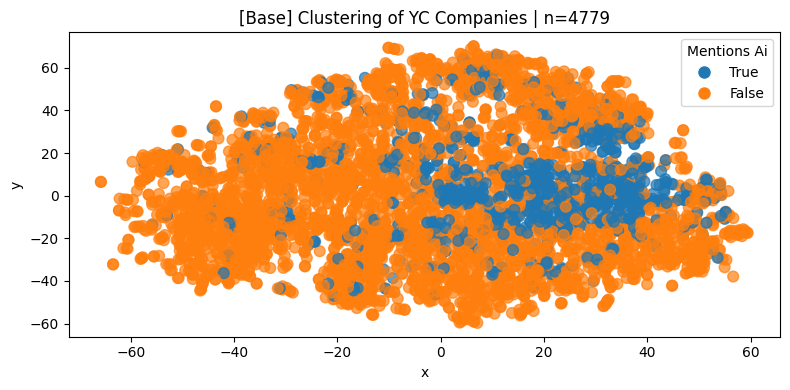

In [8]:
flush_memory() 
base_embeddings =  get_embeddings(model, yc_desc, "", max_length=max_seq_length)
base_reduced_dims = reduce_dimensions(base_embeddings, 2)  

save_json(tensor_to_json(base_embeddings), 'data/base_embeddings.json')
plot_clusters(base_reduced_dims, df, color_by='mentions_ai', title=f"[Base] Clustering of YC Companies | n={num_samples}")   ;

Processing batches:   0%|          | 0/80 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches: 100%|██████████| 80/80 [06:41<00:00,  5.02s/it]


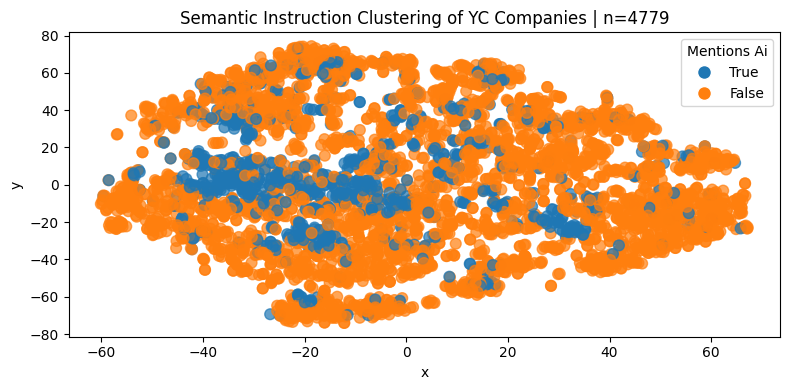

In [9]:
semantic_clustering_instruction = "Given a company description, retrieve other companies that are semantically similar or are in the same domain." 
semantic_clustering_embeddings =  get_embeddings(model, yc_desc, semantic_clustering_instruction, max_length=max_seq_length )
    
semantic_reduced_dims = reduce_dimensions(semantic_clustering_embeddings, 2)  
save_json(tensor_to_json(semantic_clustering_embeddings), 'data/semantic_embeddings.json')
plot_clusters(semantic_reduced_dims, df, color_by='mentions_ai', title=f"Semantic Instruction Clustering of YC Companies | n={num_samples}") ;

Processing batches:   0%|          | 0/80 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches: 100%|██████████| 80/80 [06:42<00:00,  5.03s/it]


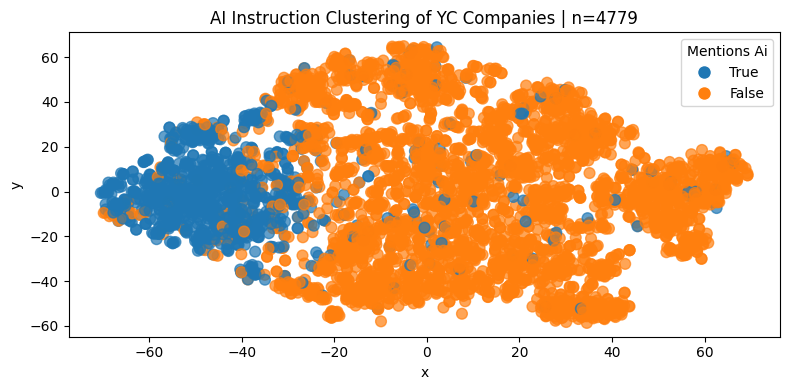

In [10]:
flush_memory() 
ai_clustering_instruction = "Classify the company description, as Artificial Intelligence (AI)  or not artificial intelligence. \nQuery" 
ai_clustering_embeddings =  get_embeddings(model, yc_desc, ai_clustering_instruction, max_length=max_seq_length)

ai_reduced_dims = reduce_dimensions(ai_clustering_embeddings, 2)  
save_json(tensor_to_json(ai_clustering_embeddings), 'data/ai_embeddings.json')
plot_clusters(ai_reduced_dims, df , color_by='mentions_ai', title=f"AI Instruction Clustering of YC Companies | n={num_samples}");

Processing batches:   0%|          | 0/80 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches: 100%|██████████| 80/80 [06:37<00:00,  4.97s/it]


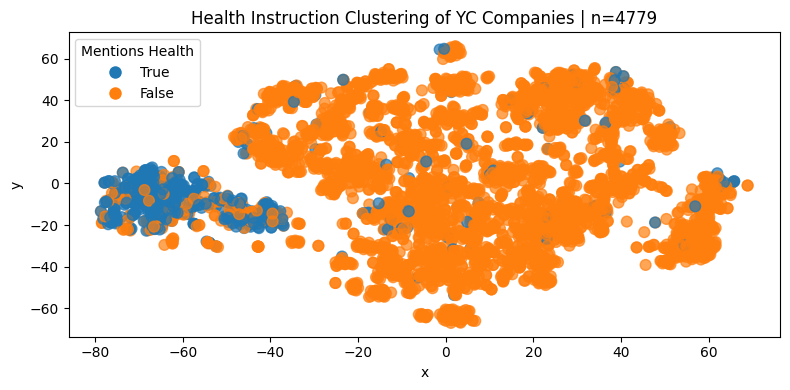

In [11]:
flush_memory()
health_clustering_instruction = "Classify the company description as health domain or not health domain. \nQuery" 

health_clustering_embeddings =  get_embeddings(model, yc_desc, health_clustering_instruction, max_length=max_seq_length)

health_reduced_dims = reduce_dimensions(health_clustering_embeddings, 2)  
save_json(tensor_to_json(health_clustering_embeddings), 'data/health_embeddings.json')
plot_clusters(health_reduced_dims, df , color_by='mentions_health', title=f"Health Instruction Clustering of YC Companies | n={num_samples}") ;

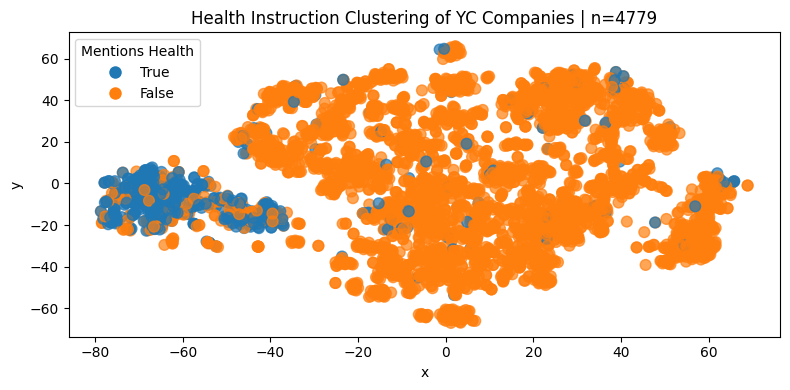

In [12]:
plot_clusters(health_reduced_dims, df , color_by='mentions_health', title=f"Health Instruction Clustering of YC Companies | n={num_samples}") ;

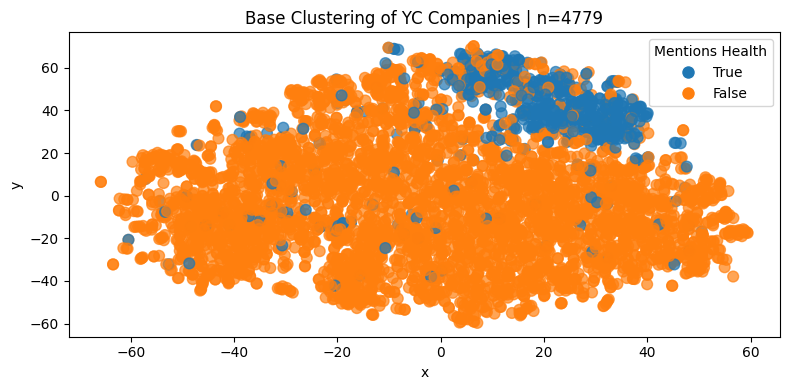

In [13]:
plot_clusters(base_reduced_dims, df , color_by='mentions_health', title=f"Base Clustering of YC Companies | n={num_samples}") ;